### Define Model

For notational ease, let our data set $X$ be a list of vectors in $R^3$, where the number of times a vector $x_i$ appears in the list is equal to the synapse value for that vector in our original data set (if the vector does not appear at all in the data set, don't include it).

As we have seen through 3d scatter plots, the data can be seen as slices of data across the y-z plane for fixed values of x. Let $L = \{l_1, l_2, ..., l_m\}$ be the set of these x values. We can now turn our data set X, an unlabeled list of vectors in $R^3$, into labeled data by treating the x value of each vector as the label, and thus the set of possible labels is L. In other words, we will treat our data set X, as a list of labels. There are 108 labels (x-values) so our data set X follows a multinomial distribution with parameters $n=|X|, \pi=(p_1, p_2, ..., p_108)$.

### Assumptions
$F_{0|X}=mult(|X|, \pi) \textrm{ such that } p_1=p_2...=p_{108}$
$F_{1|X}=mult(|X|, \pi) \textrm{ such that } p_1 \neq p_2, p_1 \neq p_3, ..., p_1 \neq p_{108}$


### Statistical test

We will test whether or not the number of synapses are distributed uniformly across each 'slice'. In other words does X follow a multinomial distribution where each cell has equal probabilities.

$H_0: \textrm{ all cells have equal probability }$

$H_A: \textrm{ cells do not have equal probability }$


### Test statistic 
We'll use Pearson's Chi Squared Test to determine whether to reject the null. First, define $E_i=\frac{|X|}{|L|}$ (recall X is our data and L is the set of labels), and define $O_i=|\{X_i \mid X_i \textrm{ has label } l_i\}$. In other words, $E_i$ is the expected number of data points with label $l_i$ and $O_i$ is the actual number. Our test statistic is
$$
T = \sum_{i = 1}^M \frac{(O_i - E_i)^2}{E_i}
$$
and it approximately follows a chi-squared distribution with M-1 degrees of freedom. Therefore, given a signifigance level, $\alpha$, we can use the inverse CDF of the chi-squared distribution to determine a critical value. When T is greater than the critical value, we can reject the null.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools
import urllib2
import scipy.stats as stats

%matplotlib inline

np.random.seed(1)
alpha = .025
url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)
num_samples = 250 # how many different sized samples to draw
N = np.sum(csv[:, -1]) # total data set size
L = np.unique(csv[:, 0]) # list of labels

# sample sizes to iterate over
initial_samp_size = 100
sample_sizes = np.linspace(initial_samp_size, 10000, num_samples, dtype='int32')

### Step 4a: Sample data from null

In [2]:
# simulated sampling under the null
repeats = 500 # how many repitions per sample size
pi_null = np.array([1.0/float(len(L))]*len(L)) # pi vector under the null
power_null = []
for s in sample_sizes:
    power = 0
    E_i = pi_null*s # expected per label
    for r in xrange(repeats):
        null_data = np.random.multinomial(s, pi_null)
        chi_sq = stats.chisquare(null_data, E_i)
        p_value = chi_sq[1]
        # can we reject the null hypothesis
        if p_value < alpha:
            power = power + 1
    power_null.append(float(power)/float(repeats))


### Step 4b: Sample data from alternate

In [3]:
# simulated sampling under alternate
repeats = 500 # how many repitions per sample size
power_alt = []
pi_alt = np.random.rand(len(L)) # create a pi vector (probabilities)
pi_alt = pi_alt/np.sum(pi_alt) # make probs sum to 1
for s in sample_sizes:
    power = 0
    E_i = pi_null*s # all labels have equal expectancy
    for r in xrange(repeats):
        alt_data = np.random.multinomial(s, pi_alt) # use pi vector to gen data
        chi_sq = stats.chisquare(alt_data, E_i)
        p_value = chi_sq[1]
        # can we reject the null hypothesis
        if p_value < alpha:
            power = power + 1
    power_alt.append(float(power)/float(repeats))

### Step 5: Plot power vs n

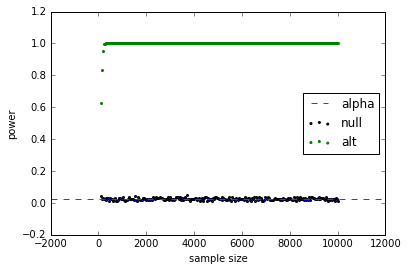

In [4]:
plt.scatter(sample_sizes, power_null, hold=True, label='null', s=4)
plt.scatter(sample_sizes, power_alt, color='green', hold=True, label='alt', s=4)
plt.xlabel('sample size')
plt.ylabel('power')
plt.axhline(alpha, color='red', linestyle='--', label='alpha')
plt.legend(loc=5)
plt.show()

### Apply to data

In [5]:
# make data set of synapse labels (x coordinates)
X = []
def build_label_set(row):
    global X
    s = int(row[-1])
    new_vals = [int(row[0])]*s
    X.extend(new_vals)
    return 0
np.apply_along_axis(build_label_set, 1, csv)
X = np.array(X)

# run chi-squared test
E_i = np.array([float(len(X))/float(len(L)) for l in L]) #E_i constant across all i
O_i = np.array([np.count_nonzero(np.where(X == int(l))) for l in L])
p_value = stats.chisquare(O_i, E_i)[1]
print 'Observed # of synapses per x-value: '
print O_i
print 'p-value: ' + str(p_value)

Observed # of synapses per x-value: 
[  370   703  1058  1519  2728  6247 13551 29241 56201 74674 78445 79804
 81220 83358 82507 79026 80200 84079 84460 83123 85578 82217 84371 88905
 88002 86350 84831 84243 82854 83963 85951 82557 79505 80330 81446 80438
 79915 83665 82132 84527 87926 85139 80892 77962 81763 81361 83825 83975
 83097 79459 78157 79097 77934 78514 79018 78773 79379 80428 78980 80569
 82042 83000 83542 83252 77737 81389 83446 80265 82607 86158 88339 82563
 84530 86578 86263 90027 91574 91131 87319 84046 85032 87601 85636 84557
 88864 87517 90393 91710 88635 83968 86721 90120 89765 85222 82429 81016
 80981 81288 69984 46899 23021 11425  5640  3076  1915  1751  1518  1143]
p-value: 0.0


### Reflect

These results suggest that the number of synapses is not evenly distributed for a given x value. We can also further conclude that the distribution of synapses throughout the entire euclidean space, $$f(x, y, z)=P(\textrm{synapse at (x, y, z)})$$ is not uniform (since the test we just ran shows that the marginal distribution of X is non-uniform).